# MD Simulations of NTRKs

This notebook analyses results from MD simulations of inhibitors larotrectinib, selitrectinib and repotrectinib docked into NTRK1-3.

## 1. System preparation

## 1.1 Docked structures

#### Data can be found in `../docking/docking.ipynb`

PDB structures `4YNE`, `4AT3`, and `6KZD` were used as structures for NTRK1, NTRK2, and NTRK3 respectively. 

A short summary of how structures were produced is shown below (check `../docking/docking.ipynb` for a full description):

* NTRK structures for docking were chosen based on searching the KLIFS database for NTRK entries in complex with ligands similar to the core structure of larotrectinib.
* Both `4YNE` and `4AT3` are in the DFG in/$\alpha$C helix out conformation, whilst `6KZD` is in the DFG out/$\alpha$C helix out conformation.
* OESpruce was not able to model all missing residues.
* Docking results were good for NTRK1 and NTRK2 compared to binding modes in Figure 1 from [Drilon et al. 2017](https://cancerdiscovery.aacrjournals.org/content/7/9/963).
* Docking into NTRK3 in the wrong conformation gave worse results. Another approach was performed using the coordinates of the nitrogen atom named NAN of the co-crystalized ligand in `6KZD` as hint coordinates for chemgauss docking. 

## 1.2 Adding missing residues

#### Data can be found in: `./data/add_missing_loops/`

All models created via docking contained missing loop residues that were not modelled by OESpruce.

* `4YNE` contained 4 missing loops (between 2-5 residues missing in each loop).
* `4AT3` contained 4 missing loops (between 2-4 residues missing in each loop).
* `6KZD` contained 2 missing loops (between 12-16 residues missing in each loop).

[MODELLER](https://salilab.org/modeller/) was used to add in the short loops in both `4YNE` and `4AT3`. Since `6KZD` contained two large loops (12 and 16 residues respoectively) loops were not modelled in.

Alignment files were manually created using the full protein sequence and PDB file sequence (extracted via [PyMol](https://pymol.org/2/)). Any artifacts (e.g. the expression tag `GSGIR` in `4YNE`) were from the structural sequence before creating models.

A total of 200 models were created and scored using [Discret Optimised Protein Energy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2242414/) (DOPE). The best scoring DOPE models (most negative value) for each strcuture were:

* `4YNE`: 4YNE_fill.BL01040001.pdb (DOPE score -4225.328)
* `4AT3`: 4AT3_fill.BL00850001.pdb (DOPE score -3242.686)
* `6KZD`: N/A

## 1.3 Equilibration

#### Data can be found in: `./data/md_equil/`

All models were capped with ACE and NME residues at their N and C termini. `TER` cards were added at the end of each chain and the final model saved as: `<pdb_code>_prepped.pdb` (e.g. `./data/md_equil/4YNE/4YNE_prepped.pdb`).

The equilibration protocol for each system can be found in `./data/md_equil/<pdb_code>/md_equil.py`. A general overview is given below:

* Each protein:ligand system was prepared using the `amberff14sb`:`openff-1.1.0` forcefields and energy minimised.
* Temperature = 300 K, Pressure = 1 bar, Ionic strength = 150 mM NaCl. 
* Each system was equilibrated in the NPT ensemble for 5 ns.
* The final equilibrated structure was written out to a PDB file named `equilibrated_state_5ns.pdb` (e.g. `./data/md_equil/output/larotrectinib/equilibrated_state_5ns.pdb`) for visual inspection.



## 2. Production runs

Simulations of `4YNE`, `4AT3`, and `6KZD` were set to run for 500 ns (still a work in progress). Below is some initial analysis of each system. 

In [1]:
import MDAnalysis as mda
import nglview as nv

In [2]:
# import own modules for analysis (done this way to keep the notebook clean)
from scripts.notebook_modules import centre_protein, calc_rmsd, delta_cog_inhib

## 2.1 4YNE (NTRK1)

In [3]:
# Note: Trajectories have not been uploaded to the GitHub repo.
# However, if you access to them you can load them via MDAnalysis, as shown below.
# This was used locally to produce all analysis in this notebook.
ntrk1_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/4YNE/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4YNE/output/repotrectinib/pr_output_traj.xtc")}

ntrk1_systems_cent = centre_protein(ntrk1_systems)

In [4]:
view = nv.show_mdanalysis(ntrk1_systems_cent['larotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=9999)

In [5]:
view = nv.show_mdanalysis(ntrk1_systems_cent['selitrectinib'])
view.center()
# View with nglview
view


NGLWidget(max_frame=9999)

In [6]:
view = nv.show_mdanalysis(ntrk1_systems_cent['repotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=9999)

### 2.1.1 All NTRK1 inhibitors are stable in the `4YNE` binding pocket

Calculating RMSD for 4YNE:larotrectinib
Calculating RMSD for 4YNE:selitrectinib
Calculating RMSD for 4YNE:repotrectinib


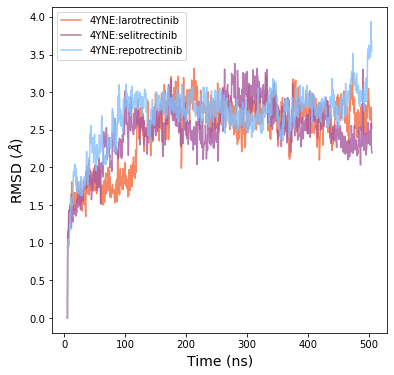

In [7]:
calc_rmsd('4YNE', ntrk1_systems_cent, skip=10)

The RMSD of the `4YNE` models (NTRK1) over 500 ns is stable, with fluctuations occuring primarily from the terminal loop regions.

current system: larotrectinib
current system: selitrectinib
current system: repotrectinib


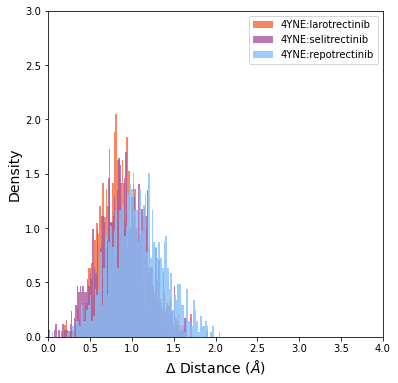

In [8]:
# Looking at how much the inhibtor's centre of geometry moves from the original docked pose
limits = {'xmin': 0, 'xmax': 4, 'ymin': 0, 'ymax': 3}

delta_cog_inhib(name='4YNE', dict_of_systs=ntrk1_systems_cent, skip=10, hist=True, save=False, **limits)

* All inhibitors in the `4YNE` structure (NTRK1) seem stable in the binding pocket with only small displacement from the original centre of geometry (of the docked pose).

## 2.2 4AT3 (NTRK2)

In [9]:
# Note: if the trajectory is not available only load the .pdb files
# trajectories have not been uploaded to the repo due to their size
ntrk2_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/4AT3/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/4AT3/output/repotrectinib/pr_output_traj.xtc")}

ntrk2_systems_cent = centre_protein(ntrk2_systems)

In [10]:
view = nv.show_mdanalysis(ntrk2_systems_cent['larotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=9999)

In [11]:
view = nv.show_mdanalysis(ntrk2_systems_cent['selitrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=9999)

In [12]:
view = nv.show_mdanalysis(ntrk2_systems_cent['repotrectinib'])
view.center()
# View with nglview
view

NGLWidget(max_frame=9999)

### 2.2.1 NTRK2 inhibitors show varied stability in the `4AT3` binding pocket, with repotrectinib occupying two sites

Calculating RMSD for 4AT3:larotrectinib
Calculating RMSD for 4AT3:selitrectinib
Calculating RMSD for 4AT3:repotrectinib


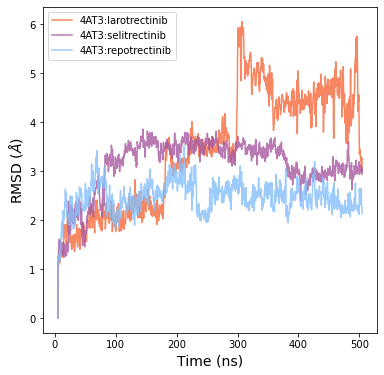

In [13]:
calc_rmsd('4AT3', ntrk2_systems_cent, skip=10)

current system: larotrectinib
current system: selitrectinib
current system: repotrectinib


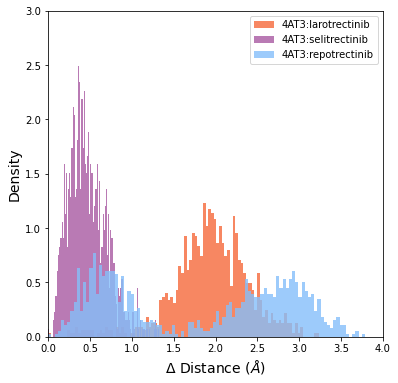

In [14]:
# Looking at how much the inhibtor's centre of geometry moves from the original docked pose
limits = {'xmin': 0, 'xmax': 4, 'ymin': 0, 'ymax': 3}

delta_cog_inhib('4AT3', ntrk2_systems_cent, skip=10, hist=True, save=False, **limits)

* All inhibitors in the `4AT3` structure (NTRK2) exhibit slightly different stabilities in the binding pocket:
    * Larotrectinib is relatively stable, however shows greater displacement than in `4YNE`.
    * Selitrectinib is very stable throughout the simulation, showing very little displacemnt from the docked pose.
    * Repotrectinib undergoes several displacement events (although still in the binding pocket) -> possibly two metastable states(?).

## 2.3 6KZD (NTRK3)

In [ ]:
# FIXME: Need to centre both chains in 6KZD

# Note: if the trajectory is not available only load the .pdb files
# trajectories have not been uploaded to the repo due to their size
ntrk3_systems = {'larotrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/larotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/larotrectinib/pr_output_traj.xtc"),
                'selitrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/selitrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/selitrectinib/pr_output_traj.xtc"),
                'repotrectinib': mda.Universe(
    "./data/md_equil/6KZD/output/repotrectinib/equilibrated_state_5ns.pdb",
    "./data/md_production_run/6KZD/output/repotrectinib/pr_output_traj.xtc")}

ntrk3_systems_cent = centre_protein(ntrk3_systems, wrap=True)

In [ ]:
view = nv.show_mdanalysis(ntrk3_systems_cent['larotrectinib'])
view.center()
# View with nglview
view